In [1]:
import os
from pathlib import Path
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

# 1. Simulation

In [2]:
#############
# USER CELL #
#############

# set name of this simulation
simulation_name = 'prem_5s__no_3d_mantle_crust__hetero_fuji_pacific_usarray'

In [3]:
input_dir = Path('simulations/' + simulation_name + '/input')
input_dir.mkdir(exist_ok=True, parents=True)

# 2. Earth model

In [4]:
#############
# USER CELL #
#############

# set earth model parameters

# 1D model
# Choose one from ak135, iasp91, prem_ani (anisotropic PREM), prem_iso (isotropic PREM).
model_1D = 'prem_ani'

# mesh period (sec)
# 1: very expensive
# 2: expensive
# 5: moderate
# 10+: fast
# The resolvable diameter of a heterogeneity ≈ period * (Vp at that depth),
# so the period is dominated by the size of the wanted heterogeneities.
model_period = 5.

# 3D mantle
# True: use s40rts
# False: no 3D mantle
# Turning on 3D mantle will NOT make simulations more expensive, but 3D ray-tracing
# should better be used for migration for consistency in travel time. 
model_mantle_3D = False

# 3D crust
# True: use Crust 1.0
# False: no 3D crust
# Turning on 3D crust will make simulations more expensive due to a smaller time step
# within the oceanic crust. The seismograms will look more chaotic due to crust 
# scattering, making migration more challenging.
model_crust_3D = False

# file of scatterers
# Use None if no scatterers
# Each row defines a spherical scatterer, with the SEVEN columns being:
# latitude_degree longitude_degree depth_km radius_km dvp dvs drho
model_scatterer_file = 'templates/example_hetero_south_pacific.txt'

In [5]:
# For example, I used the following code to generate 
# templates/example_hetero_south_pacific.txt on a structured grid
hetero_radius = model_period * 12.5  # 12.5 is VP in lower mantle
with open('templates/example_hetero_south_pacific.txt', 'w') as fs:
    for depth in [500, 1400, 2300]:
        for lat in [-10, 0, 10, 20, 30]:
            for lon in [190, 200, 210, 220, 230, 240]:
                fs.write(f'{lat} {lon} {depth} 100 -.05 -.05 0\n')

In [6]:
# generate mesh
cmd = f"python -m salvus_mesh_lite.interface AxiSEM --basic.model {model_1D} "\
f"--basic.period {model_period} --output_file {input_dir}/model_1D.e --overwrite_file "\
f"--advanced.elements_per_wavelength 1.25"
os.system(cmd)

0

In [7]:
# moho and CMB depth
if model_1D == 'prem_ani' or model_1D == 'prem_iso':
    moho_depth = 24.4
    cmb_depth = 2891.
elif model_1D == 'ak135':
    moho_depth = 20.
    cmb_depth = 2891.5
elif model_1D == 'iasp91':
    moho_depth = 20.
    cmb_depth = 2889.
else:
    assert False, 'Unknown 1D model.'
moho_radius = 6371. - moho_depth
cmb_radius = 6371. - cmb_depth

In [8]:
model_vol = []
model_geo = []
model_ocean = 'constant'

if model_mantle_3D:
    model_vol.append(f's40rts$.4${cmb_radius}${moho_radius}')

if model_crust_3D:
    model_vol.append(f'crust1$false$false$true${moho_radius}')
    model_geo.append(f'crust1$false$1.$1.$2$.5$true$6151.%{moho_radius}')
    model_ocean = 'crust1'
    
if model_scatterer_file is not None:
    scat_data = np.loadtxt(model_scatterer_file)
    for s in scat_data:
        for i, prop in enumerate(['VP', 'VS', 'RHO']):
            val = float(s[4 + i])
            if abs(val) > 1e-10: 
                model_vol.append(f'bubble${prop}$Ref3D${val}${s[3]}${s[2]}${s[0]}${s[1]}')

In [9]:
# inparam.model
with open('templates/inparam.model', 'r') as fs:
    inp = fs.read()
inp = inp.replace('__MODEL_3D_VOLUMETRIC_NUM__', str(len(model_vol)))
inp = inp.replace('__MODEL_3D_VOLUMETRIC_LIST__', 
                  'MODEL_3D_VOLUMETRIC_LIST ' + '\nMODEL_3D_VOLUMETRIC_LIST '.join(model_vol))
inp = inp.replace('__MODEL_3D_GEOMETRIC_NUM__', str(len(model_geo)))
inp = inp.replace('__MODEL_3D_GEOMETRIC_LIST__', ' '.join(model_geo))
inp = inp.replace('__MODEL_3D_OCEAN_LOAD__', model_ocean)
with open(f'{input_dir}/inparam.model', 'w') as fs:
    fs.write(inp)
    
# inparam.nu
with open('templates/inparam.nu', 'r') as fs:
    inp = fs.read()
if model_crust_3D or model_scatterer_file is not None:
    nu = int(1500 // model_period)
elif model_mantle_3D:
    nu = 100
else:
    nu = 2
inp = inp.replace('__NU__', str(nu))
with open(f'{input_dir}/inparam.nu', 'w') as fs:
    fs.write(inp)
    
# inparam.advanced
os.system(f'cp templates/inparam.advanced {input_dir}/inparam.advanced')

0

# 3. Earthquake


In [10]:
#############
# USER CELL #
#############

# set earthquake by CMTSOLUTION
cmt_file = 'templates/example_CMTSOLUTION'

In [11]:
# CMTSOLUTION
os.system(f'cp {cmt_file} {input_dir}/CMTSOLUTION')

0

# 4. Stations


In [12]:
#############
# USER CELL #
#############

# set stations
# Each row for a station with 6 columns:
# NAME NETWORK LATITUDE LONGITUDE unused DEPTH
station_file = 'templates/example_STATIONS'

# record length
# Make sure this covers all needed phases
record_length = 1200.

In [13]:
# STATIONS
os.system(f'cp {station_file} {input_dir}/STATIONS')

# inparam.time_src_recv
with open('templates/inparam.time_src_recv', 'r') as fs:
    inp = fs.read()
inp = inp.replace('__HALF_DURATION__', str(model_period))
inp = inp.replace('__LENGTH__', str(record_length))
with open(f'{input_dir}/inparam.time_src_recv', 'w') as fs:
    fs.write(inp)

# 5. Plot for quick verification

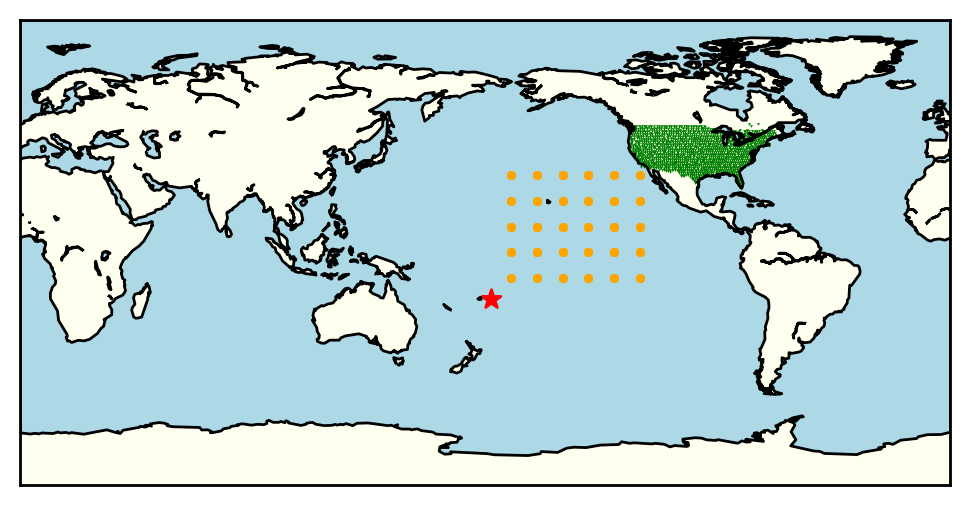

In [14]:
plt.figure(dpi=200)
# map
m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
m.drawcoastlines()
m.fillcontinents(color='ivory',lake_color='lightblue')
m.drawmapboundary(fill_color='lightblue')

# hetero
if model_scatterer_file is not None:
    m.scatter(scat_data[:, 1], scat_data[:, 0], c='orange', s=5)

# earthquake
e_data = np.loadtxt(f'{input_dir}/CMTSOLUTION', skiprows=1, dtype=str, delimiter=':')
e_lat = float(e_data[3, 1])
e_lon = float(e_data[4, 1])
if e_lon < 0:
    e_lon += 360.
m.scatter(e_lon, e_lat, c='red', s=50, marker='*')

# stations
s_data = np.loadtxt(f'{input_dir}/STATIONS', dtype=str)
s_lat = s_data[:, 2].astype(float)
s_lon = s_data[:, 3].astype(float)
s_lon[s_lon < 0] += 360.
m.scatter(s_lon, s_lat, c='green', s=1, marker='v', linewidth=0)
plt.show()

# 5. Job script


In [15]:
#############
# USER CELL #
#############

# set slurm parameters
slurm_head = \
'''#SBATCH --time=1-00:00:00
#SBATCH --partition=day
#SBATCH --nodes=20
#SBATCH --ntasks=960'''

In [16]:
# submit.sh
with open('templates/submit.sh', 'r') as fs:
    inp = fs.read()
inp = inp.replace('__HEAD__', slurm_head)
inp = inp.replace('__NAME__', simulation_name)
inp = inp.replace('__NP__', slurm_head.split('=')[-1])
with open(f'{input_dir}/../submit.sh', 'w') as fs:
    fs.write(inp)